In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical, pad_sequences

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                data.append((label, points))

In [3]:
print(data[0])

('arrow', array([[ 58., 226.],
       [ 60., 225.],
       [ 63., 223.],
       [ 66., 222.],
       [ 69., 219.],
       [ 72., 217.],
       [ 76., 215.],
       [ 78., 214.],
       [ 83., 212.],
       [ 88., 210.],
       [ 93., 207.],
       [ 98., 204.],
       [101., 203.],
       [104., 201.],
       [111., 198.],
       [117., 195.],
       [120., 194.],
       [129., 191.],
       [135., 187.],
       [140., 184.],
       [143., 183.],
       [150., 180.],
       [155., 177.],
       [157., 175.],
       [162., 173.],
       [165., 172.],
       [167., 170.],
       [168., 168.],
       [169., 165.],
       [167., 165.],
       [165., 165.],
       [159., 164.],
       [156., 163.],
       [148., 162.],
       [143., 161.],
       [137., 160.],
       [129., 160.],
       [123., 161.],
       [120., 162.],
       [117., 162.],
       [113., 163.],
       [111., 165.],
       [114., 165.],
       [117., 164.],
       [126., 162.],
       [135., 160.],
       [144., 158.],
   

In [13]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
#X = np.array(sequences)
sequences = pad_sequences(
    sequences, padding="pre", dtype='float32'
)
X=sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'check', 'arrow', 'caret'}
{0, 1, 2}
3
(2, 65, 2) (1, 65, 2) (2, 3) (1, 3)


In [73]:
# Define the model
model = Sequential()

model.add(GRU(64, dropout=0.03)) # 96?
#model.add(GRU(96, dropout=0.03))

model.add(BatchNormalization())
model.add(Dropout(.3)) # input shape?
model.add(Dense(64))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(32))

model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(3))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [74]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 8.1130 - accuracy: 1.0000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 57ms/step - loss: 8.3769 - accuracy: 0.5000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 66ms/step - loss: 2.8977 - accuracy: 0.5000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 60ms/step - loss: 1.0185 - accuracy: 0.5000 - val_loss: 1.1921e-07 - val_accuracy: 1.0000 - lr: 0.0010


In [75]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_55 (GRU)                (None, 64)                13056     
                                                                 
 batch_normalization_80 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_78 (Dropout)        (None, 64)                0         
                                                                 
 dense_78 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_81 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_79 (Dropout)        (None, 64)              

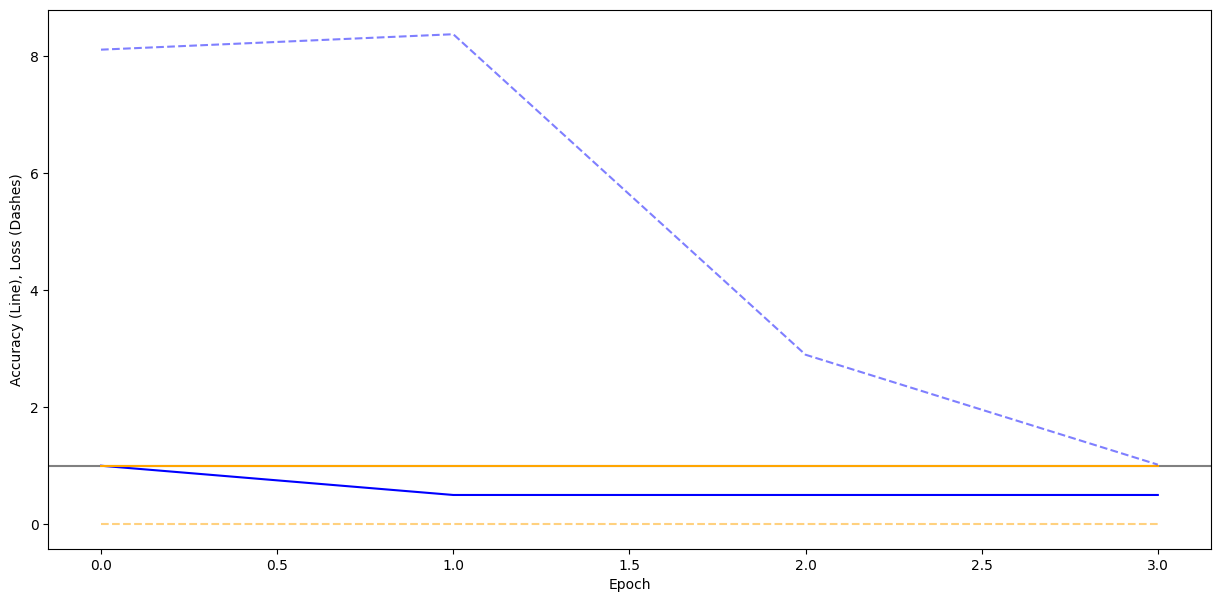

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

1/1 [==============================] - 0s 457ms/step


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (3).

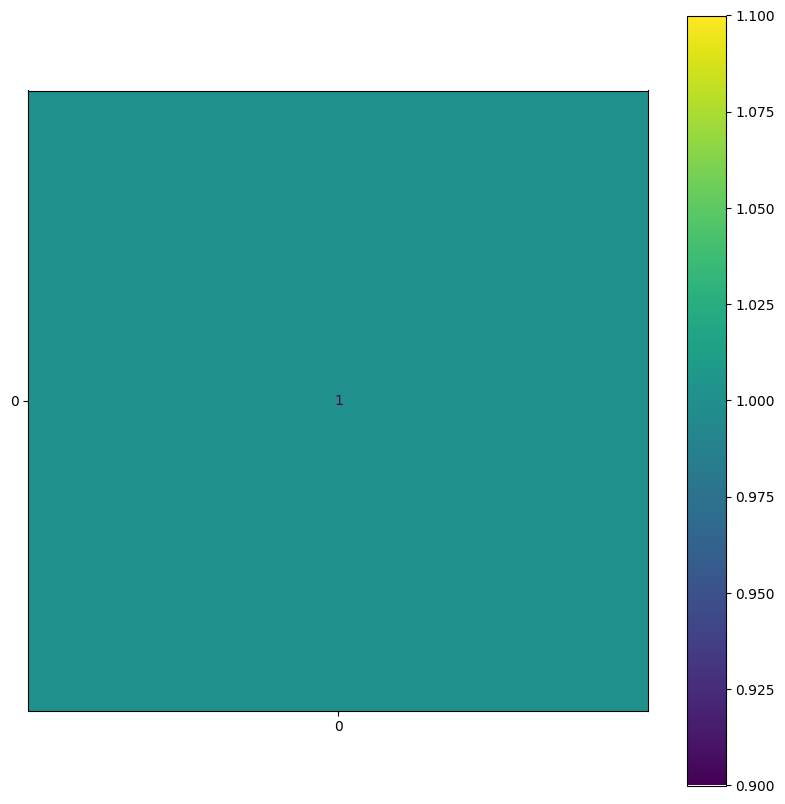

In [77]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 [==============================] - 0s 10ms/step
Label:      check
Prediction: arrow


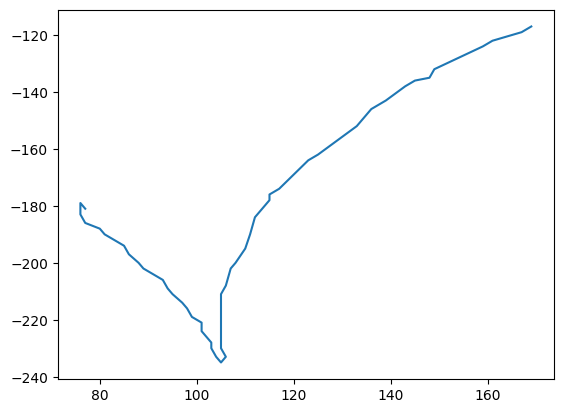

In [85]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)